# Prueba de conexion con el AFE5808A

En este documento se realizará una prueba de conexion con el AFE5808A a traves de petalinux usando la Kria Robotics KR260

### Importacion de la libreria del AFE SPI

En esta primera parte se evaluara la escritura de registros y lectura de datos en el register map a traves del slow control

In [1]:
import ctypes
import time

import matplotlib.pyplot as plt
import os
import mmap
import struct
import numpy as np
import subprocess

from dma_driver import *
from afe5808a import *

In [2]:
def run_command(command):
    """Ejecuta un comando en la terminal y muestra la salida en tiempo real."""
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    for line in process.stdout:
        print(line, end="")  # Imprime la salida en tiempo real

    process.wait()  # Esperar a que termine el proceso
    if process.returncode != 0:
        print(f"\nError en el comando: {command}")
        print(process.stderr.read())

In [3]:
run_command("xmutil unloadapp")
run_command("xmutil loadapp kria_serdes")

remove from slot 0 returns: 0 (Ok)
kria_serdes: loaded to slot 0


In [4]:
# Cambiar propietario de dispositivos
devices = ["/dev/spidev3.0"]
for dev in devices:
    run_command(f"chown petalinux:petalinux {dev}")
    run_command(f"chmod 777 {dev}")

In [5]:
# Exportar los GPIOs

run_command(f"chown petalinux:petalinux -R /sys/class/gpio/gpiochip497/*")
run_command(f"chown petalinux:petalinux -R /sys/class/gpio/gpiochip498/*")

gpios = [497, 498, 499]
for gpio in gpios:
    run_command(f"echo {gpio} | sudo tee /sys/class/gpio/export")
    
for gpio in gpios:
    run_command(f"chown petalinux:petalinux -R /sys/class/gpio/gpio{gpio}/*")

497
498
499


### Creacion del objeto afe5808a

Se cargan los perifericos para el manejo del control lento del AFE

In [6]:
# Cargar la biblioteca compartida
my_library = ctypes.CDLL('./afe5808a_lib.so')

In [7]:
# Peropheral config
my_library.MX_GPIO_Init() # Initialize the GPIO driver


0

In [8]:
my_library.MX_SPI3_Init() # Initialize the SPI driver

0

### Instanciacion de los objetos dentro de la libreria

Se instancia el objeto del AFE para utilizarlo

In [9]:
# AFE Initialization
my_library.MX_AFE0_Init() # Initialize the AFE0

0

---

## Instanciando el objeto AFE 0

con este objeto manejaremos los datos del AFE

In [10]:
# Accede a la instancia de la estructura (en este caso, hafe0)
hafe0 = my_library.hafe0

# Convierte la instancia a la estructura definida en Python
hafe0_py = ctypes.cast(hafe0, ctypes.POINTER(AFE_HandleTypeDef)).contents

---

### Prueba de escritura y lectura de registros crudos

Aqui se probara la lectura y la escritura de registros crudos

In [11]:
writeData = (ctypes.c_uint16)(1)

# Cambia el valor del regitro
my_library.HAL_AFEWriteRegister(hafe0, 0, ctypes.byref(writeData))

readData = (ctypes.c_uint16)(0)
my_library.HAL_AFEReadRegister(hafe0, 0, ctypes.byref(readData))
print("REG00bits = ", hex(readData.value))

Configuring SPI MODE_2, Previous = 0, New = 3 
REG00bits =  0x0


In [12]:
readData = (ctypes.c_uint16)(0)
my_library.HAL_AFEReadRegister(hafe0, 4, ctypes.byref(readData))
print("REG01bits = ", hex(readData.value))

REG01bits =  0x0


In [13]:
readData = (ctypes.c_uint16)(0)
my_library.HAL_AFEReadRegister(hafe0, 4, ctypes.byref(readData))
print("REG01bits = ", hex(readData.value))

writeData = (ctypes.c_uint16)(0x18)
my_library.HAL_AFEWriteRegister(hafe0, 4, ctypes.byref(writeData))

readData = (ctypes.c_uint16)(0)
my_library.HAL_AFEReadRegister(hafe0, 4, ctypes.byref(readData))
print("REG00bits = ", hex(readData.value))

REG01bits =  0x0
REG00bits =  0x18


In [14]:
readData = (ctypes.c_uint16)(0)
my_library.HAL_AFEReadRegister(hafe0, 1, ctypes.byref(readData))
print("REG01bits = ", hex(readData.value))

writeData = (ctypes.c_uint16)(0x8000)
my_library.HAL_AFEWriteRegister(hafe0, 1, ctypes.byref(writeData))

readData = (ctypes.c_uint16)(0)
my_library.HAL_AFEReadRegister(hafe0, 1, ctypes.byref(readData))
print("REG00bits = ", hex(readData.value))

REG01bits =  0x0
REG00bits =  0x8000


## Configuracion basica del AFE

In [15]:
# Send the configuration sequence for AFE 0
my_library.HAL_AFE_InitialConfig(my_library.hafe0)

0

In [16]:
# Send the configuration sequence for AFE 0
my_library.HAL_AFE_ResetConfig(my_library.hafe0)

0

### Habilitar la generacion de señal rampa

In [17]:
#my_library.HAL_AFE_All0sTest(my_library.hafe0)
#my_library.HAL_AFE_ToggleTest(my_library.hafe0)
#my_library.HAL_AFE_All1sTest(my_library.hafe0)
#my_library.HAL_AFE_CustomTest(my_library.hafe0)
#my_library.HAL_AFE_SkewTest(my_library.hafe0)
#my_library.HAL_AFE_SyncTest(my_library.hafe0)
my_library.HAL_AFE_RampTest(my_library.hafe0)

0


# Lectura de datos de la DMA

In [18]:
f = open("/dev/mem", "r+b")
    
# Mapear la memoria del DMA
dma_sm = mmap.mmap(f.fileno(), DMA_MAP_SIZE, offset=DMA_SINE_ADDR)
dst_sm = mmap.mmap(f.fileno(), DST_MAP_SIZE, offset=DST_SINE_ADDR)

In [19]:
print("Resetting the DMA...")
write_dma(dma_sm, S2MM_CONTROL_REGISTER, RESET_DMA)
dma_s2mm_status(dma_sm)

print("Halting the DMA...")
write_dma(dma_sm, S2MM_CONTROL_REGISTER, HALT_DMA)
dma_s2mm_status(dma_sm)

print("Enabling all interrupts...")
write_dma(dma_sm, S2MM_CONTROL_REGISTER, ENABLE_ALL_IRQ)
dma_s2mm_status(dma_sm)

print("Writing the destination address...")
write_dma(dma_sm, S2MM_DST_ADDRESS_REGISTER, DST_SINE_ADDR)
dma_s2mm_status(dma_sm)

print("Running the S2MM channel...")
write_dma(dma_sm, S2MM_CONTROL_REGISTER, RUN_DMA)
dma_s2mm_status(dma_sm)

print("Writing S2MM transfer length of 8192 bytes...")
write_dma(dma_sm, S2MM_BUFF_LENGTH_REGISTER, DST_MAP_SIZE)
dma_s2mm_status(dma_sm)

print("Waiting for S2MM synchronization...")
dma_s2mm_sync(dma_sm)

print("Final DMA status:")
dma_s2mm_status(dma_sm)

Resetting the DMA...
Stream to memory-mapped status (0x00000001):
  Halted.

Halting the DMA...
Stream to memory-mapped status (0x00000001):
  Halted.

Enabling all interrupts...
Stream to memory-mapped status (0x00000001):
  Halted.

Writing the destination address...
Stream to memory-mapped status (0x00000001):
  Halted.

Running the S2MM channel...
Stream to memory-mapped status (0x00000000):

Writing S2MM transfer length of 8192 bytes...
Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Waiting for S2MM synchronization...
Final DMA status:
Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.



In [20]:
data = get_mem_data(dst_sm, DST_MAP_SIZE)

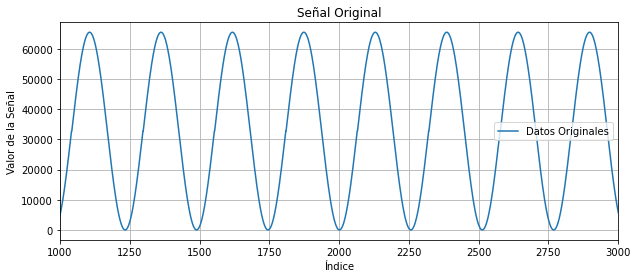

In [21]:
plot_mem_data(data)

In [22]:
def plot_data(data):
    # Graficar los datos y su derivada
    plt.figure(figsize=(10, 4))

    # Graficar los datos originales
    #plt.subplot(2, 1, 1)
    plt.plot(data, label="Datos Originales")
    plt.title("Señal Original")
    plt.xlabel("Índice")
    plt.ylabel("Valor de la Señal")
    plt.grid(True)
    plt.legend()
    plt.xlim([0,8191])
    #plt.ylim([data[1000],data[7000]])
    #plt.show()

In [23]:
#my_library.HAL_AFE_All0sTest(my_library.hafe0)
#my_library.HAL_AFE_ToggleTest(my_library.hafe0)
my_library.HAL_AFE_All1sTest(my_library.hafe0)
#my_library.HAL_AFE_CustomTest(my_library.hafe0)
#my_library.HAL_AFE_SkewTest(my_library.hafe0)
#my_library.HAL_AFE_SyncTest(my_library.hafe0)
#my_library.HAL_AFE_RampTest(my_library.hafe0)

0

In [24]:
f = open("/dev/mem", "r+b")
    
# Mapear la memoria del DMA
dma_sm = mmap.mmap(f.fileno(), DMA_MAP_SIZE, offset=DMA_DIFF_ADDR)
dst_sm = mmap.mmap(f.fileno(), DST_MAP_SIZE, offset=DST_DIFF_ADDR)

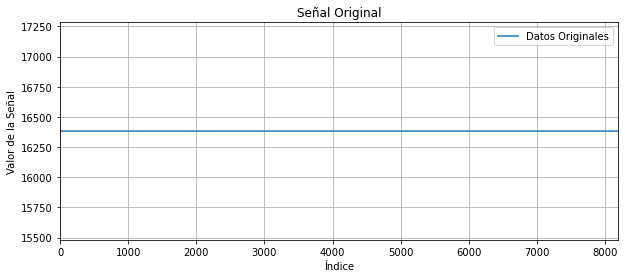

In [27]:
write_dma(dma_sm, S2MM_CONTROL_REGISTER, RESET_DMA)
write_dma(dma_sm, S2MM_CONTROL_REGISTER, HALT_DMA)
write_dma(dma_sm, S2MM_CONTROL_REGISTER, ENABLE_ALL_IRQ)
write_dma(dma_sm, S2MM_DST_ADDRESS_REGISTER, DST_SINE_ADDR)
write_dma(dma_sm, S2MM_CONTROL_REGISTER, RUN_DMA)
write_dma(dma_sm, S2MM_BUFF_LENGTH_REGISTER, DST_MAP_SIZE)

data = get_mem_data(dst_sm, DST_MAP_SIZE)

plot_data(data)
